In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pypiahmad/realistic-action-recognition-ucf50")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'realistic-action-recognition-ucf50' dataset.
Path to dataset files: /kaggle/input/realistic-action-recognition-ucf50


In [4]:
# Define the 18 selected action classes
selected_classes = [
    "Basketball",
    "Diving",
    "HorseRace",
    "JumpRope",
    "VolleyballSpiking",
    "WalkingWithDog",
    "BenchPress",
    "Biking",
    "GolfSwing",
    "HighJump",
    "Kayaking",
    "PullUps",
    "PushUps",
    "RopeClimbing",
    "SkateBoarding",
    "SoccerJuggling",
    "Swing",
    "TrampolineJumping"
]

# UCF50 dataset path
dataset_path = os.path.join(path, "UCF50")

# Confirm folder structure
for cls in selected_classes:
    print(f"{cls} → Total videos:", len(os.listdir(os.path.join(dataset_path, cls))))

Basketball → Total videos: 137
Diving → Total videos: 153
HorseRace → Total videos: 127
JumpRope → Total videos: 148
VolleyballSpiking → Total videos: 116
WalkingWithDog → Total videos: 123
BenchPress → Total videos: 160
Biking → Total videos: 145
GolfSwing → Total videos: 142
HighJump → Total videos: 123
Kayaking → Total videos: 157
PullUps → Total videos: 120
PushUps → Total videos: 106
RopeClimbing → Total videos: 130
SkateBoarding → Total videos: 120
SoccerJuggling → Total videos: 156
Swing → Total videos: 137
TrampolineJumping → Total videos: 119


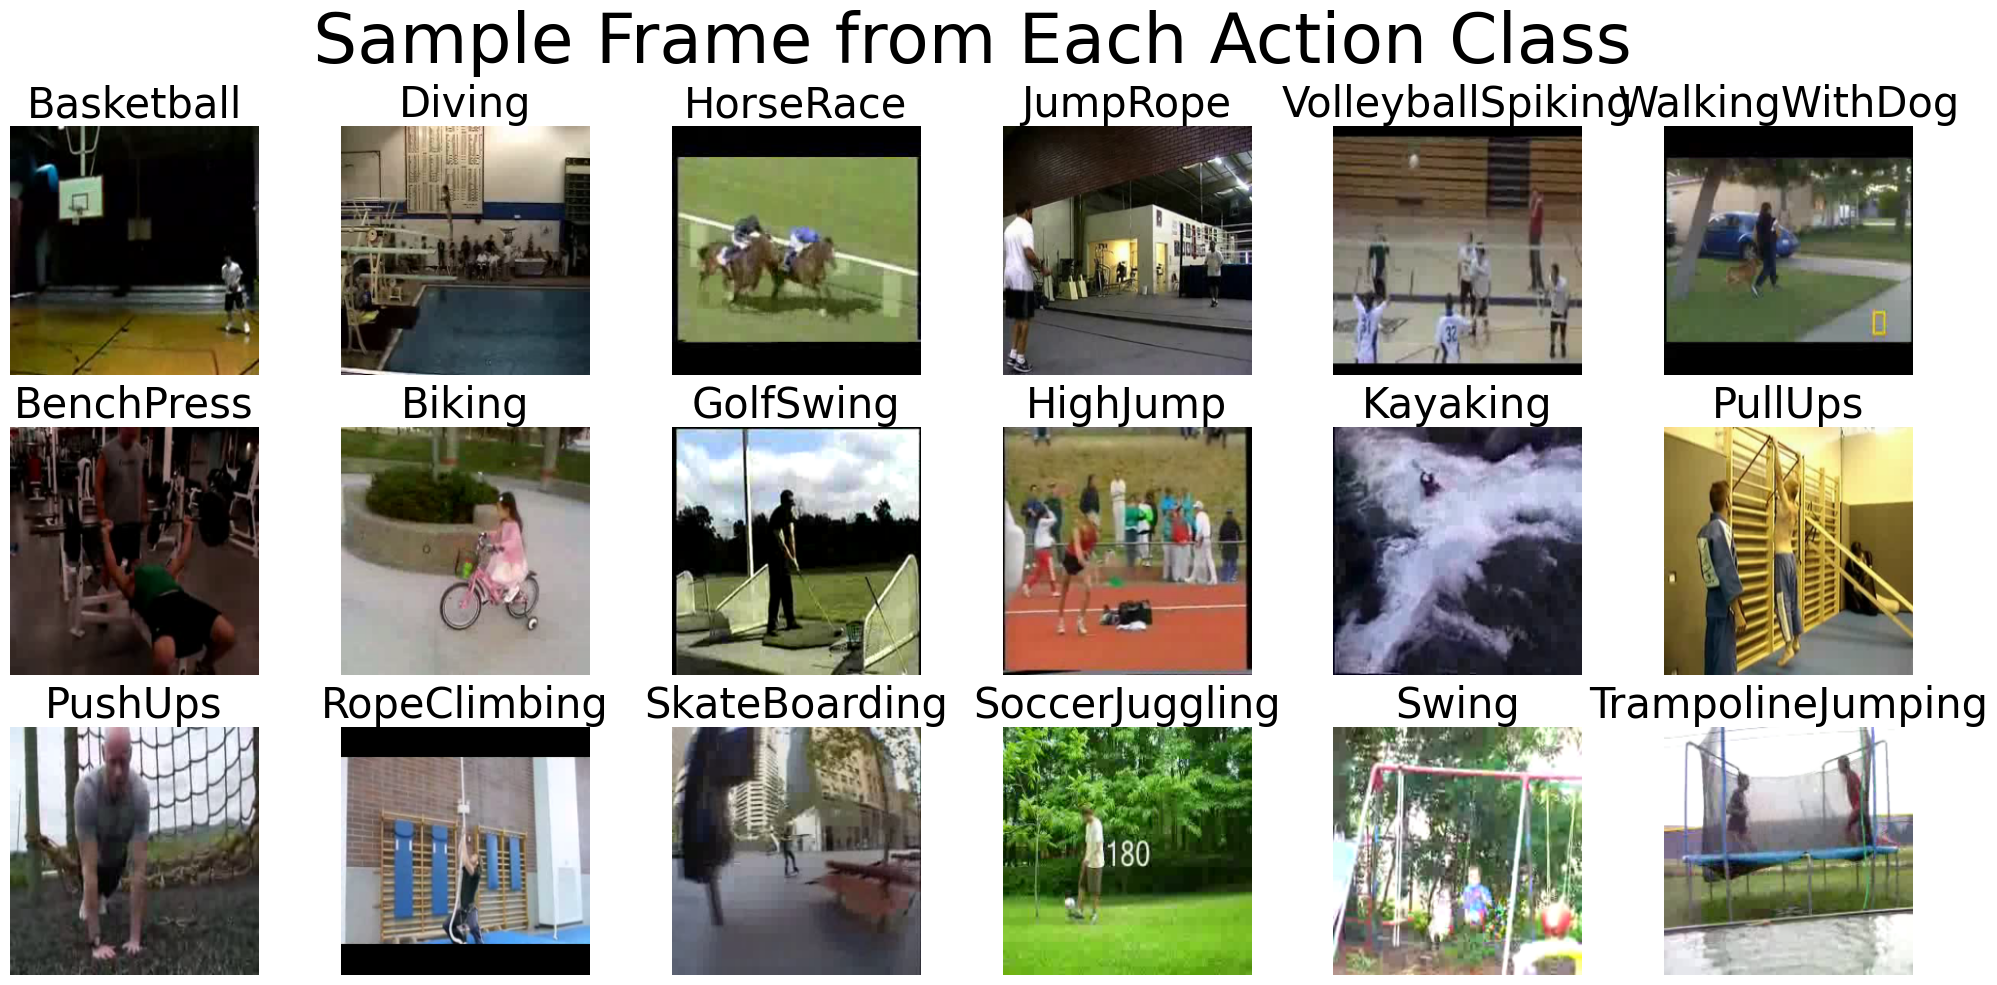

In [5]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, dataset_path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        video_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame)
            axes[i].set_title(cls , fontsize = 30)
        axes[i].axis('off')

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, dataset_path)

In [6]:
class_list = selected_classes
def extract_frames(video_path, num_frames=16, augment=False, img_size=112):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indexes = np.linspace(0, total_frames - 1, num_frames).astype(int)

    for idx in frame_indexes:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()

        if not ret:
            frame = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        frame = cv2.resize(frame, (img_size, img_size))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frames.append(frame)

    cap.release()
    frames = np.array(frames).astype("float32") / 255.0

    # Simple augmentation
    if augment:
        if np.random.rand() < 0.5:
            frames = frames[:, :, ::-1, :]  # horizontal flip

    return frames



In [7]:
def augment_video(frames):
    # Random Horizontal Flip
    if np.random.rand() < 0.5:
        frames = frames[:, :, ::-1, :]

    # Random Brightness
    if np.random.rand() < 0.5:
        frames = np.clip(frames + np.random.randint(-30, 30), 0, 255)

    return frames


In [8]:
def video_generator(class_list, dataset_path, batch_size=4, num_frames=16, augment=False, img_size=112):
    while True:
        X_batch = []
        y_batch = []

        for _ in range(batch_size):

            # Random class
            cls_idx = np.random.randint(0, len(class_list))
            cls = class_list[cls_idx]
            class_path = os.path.join(dataset_path, cls)

            # Random video
            video_name = np.random.choice(os.listdir(class_path))
            video_path = os.path.join(class_path, video_name)

            # Extract frames
            frames = extract_frames(video_path, num_frames=num_frames, augment=augment, img_size=img_size)

            X_batch.append(frames)
            y_batch.append(cls_idx)

        X_batch = np.array(X_batch)  # shape: (BATCH, FRAMES, H, W, 3)
        y_batch = tf.keras.utils.to_categorical(y_batch, num_classes=len(class_list))

        yield X_batch, y_batch




In [21]:
# Only use the 18 selected classes
class_list = selected_classes

train_gen = video_generator(class_list, dataset_path, batch_size=4, num_frames=16, augment=True)
val_gen   = video_generator(class_list, dataset_path, batch_size=4, num_frames=16, augment=False)





In [22]:
NUM_FRAMES = 16     # or 20, your choice
IMG_SIZE = 112      # or 112, 128, 224 etc.

def build_3dcnn(input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3), num_classes=5):

    model = models.Sequential()

    model.add(layers.Conv3D(64, (3,3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling3D((1,2,2)))

    model.add(layers.Conv3D(128, (3,3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D((2,2,2)))

    model.add(layers.Conv3D(256, (3,3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D((2,2,2)))

    model.add(layers.Conv3D(256, (3,3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D((2,2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model



model = build_3dcnn(num_classes=len(class_list))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 16, 112, 112,   │         5,248 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 16, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 16, 56, 56,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 8, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 8, 28, 28, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 4, 14, 14, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 4, 14, 14, 256) │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 2, 7, 7, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,736,082 (60.03 MB)

 Trainable params: 15,736,082 (60.03 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,            # stop after 3 stagnant epochs
    restore_best_weights=True,
    mode='min'             # because lower val_loss is better
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    steps_per_epoch=500,
    validation_steps=50,
    callbacks=[early_stopping]
)


Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 163s 327ms/step - accuracy: 0.7637 - loss: 0.7611 - val_accuracy: 0.8950 - val_loss: 0.3717
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 324ms/step - accuracy: 0.8129 - loss: 0.5960 - val_accuracy: 0.9200 - val_loss: 0.3403
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 324ms/step - accuracy: 0.8500 - loss: 0.4610 - val_accuracy: 0.9200 - val_loss: 0.2157
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 325ms/step - accuracy: 0.8865 - loss: 0.3586 - val_accuracy: 0.9050 - val_loss: 0.2460
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 163s 326ms/step - accuracy: 0.8935 - loss: 0.3320 - val_accuracy: 0.9500 - val_loss: 0.2006
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 325ms/step - accuracy: 0.8988 - loss: 0.3252 - val_accuracy: 0.9200 - val_loss: 0.2312
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 314ms/step - accuracy: 0.9343 - loss: 0.2087 - val_accuracy: 0.9700 - val_loss: 0.0652
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - accuracy: 0.9375 -

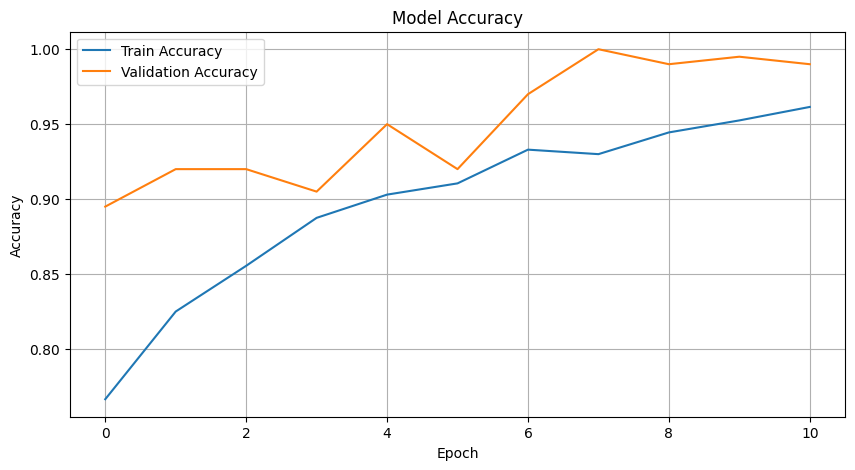

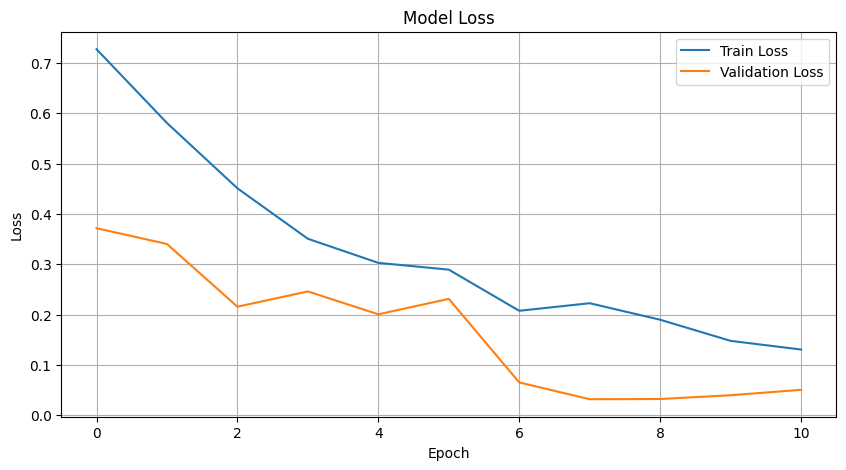

In [27]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
